<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Directory: .

  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.07.25 14:12:36      +
  ++++++++++++++++++++++++++++++++++++++++++++
kprxse = 0.7097;

k2prmp = -0.01858039299;

k3prmpf = 0.05812457857;

k3prpfwf = -0.3425892323;

k0prbhf := 0.03135884818;

k1prbhf = 0.05705266952;

k1prpfwf = -0.0001009094244;

k1prf8l = 0;

k2prbhf = 0;

k2prpfwf = -0.002222356465;

k2prmpj = 0.03934772381;

k0prbhd := 0.03147300489;

k1prbhd = -0.05711581728;

k1prpfwd = 5.894593051e-05;

k2prbhd = 0;

k2prpfwd = -0.003987126033;

k3prmpd = -0.1320148496;

k3prpfwd = 0.3331200184;

kprqsk03 := kfs;

kprqsk04 := kds;

kpeqke16 = 0;

kprqfn05 := kf;

kf = 0;

kprqdw06 := kd;

kd = 0;

kprqsk07 := kfs;

kprqsk08 := kds;

kprqfn09 := kf;

kprqdn10 := kd;

kpebsw12 = 0;

kpebsw14 = 0;

kprqfw17 := kf;

kprqdw18 := kd;

kpebsw23 := dkpeseh23_x_ab

Text(0, 0.5, 'px [rad]')

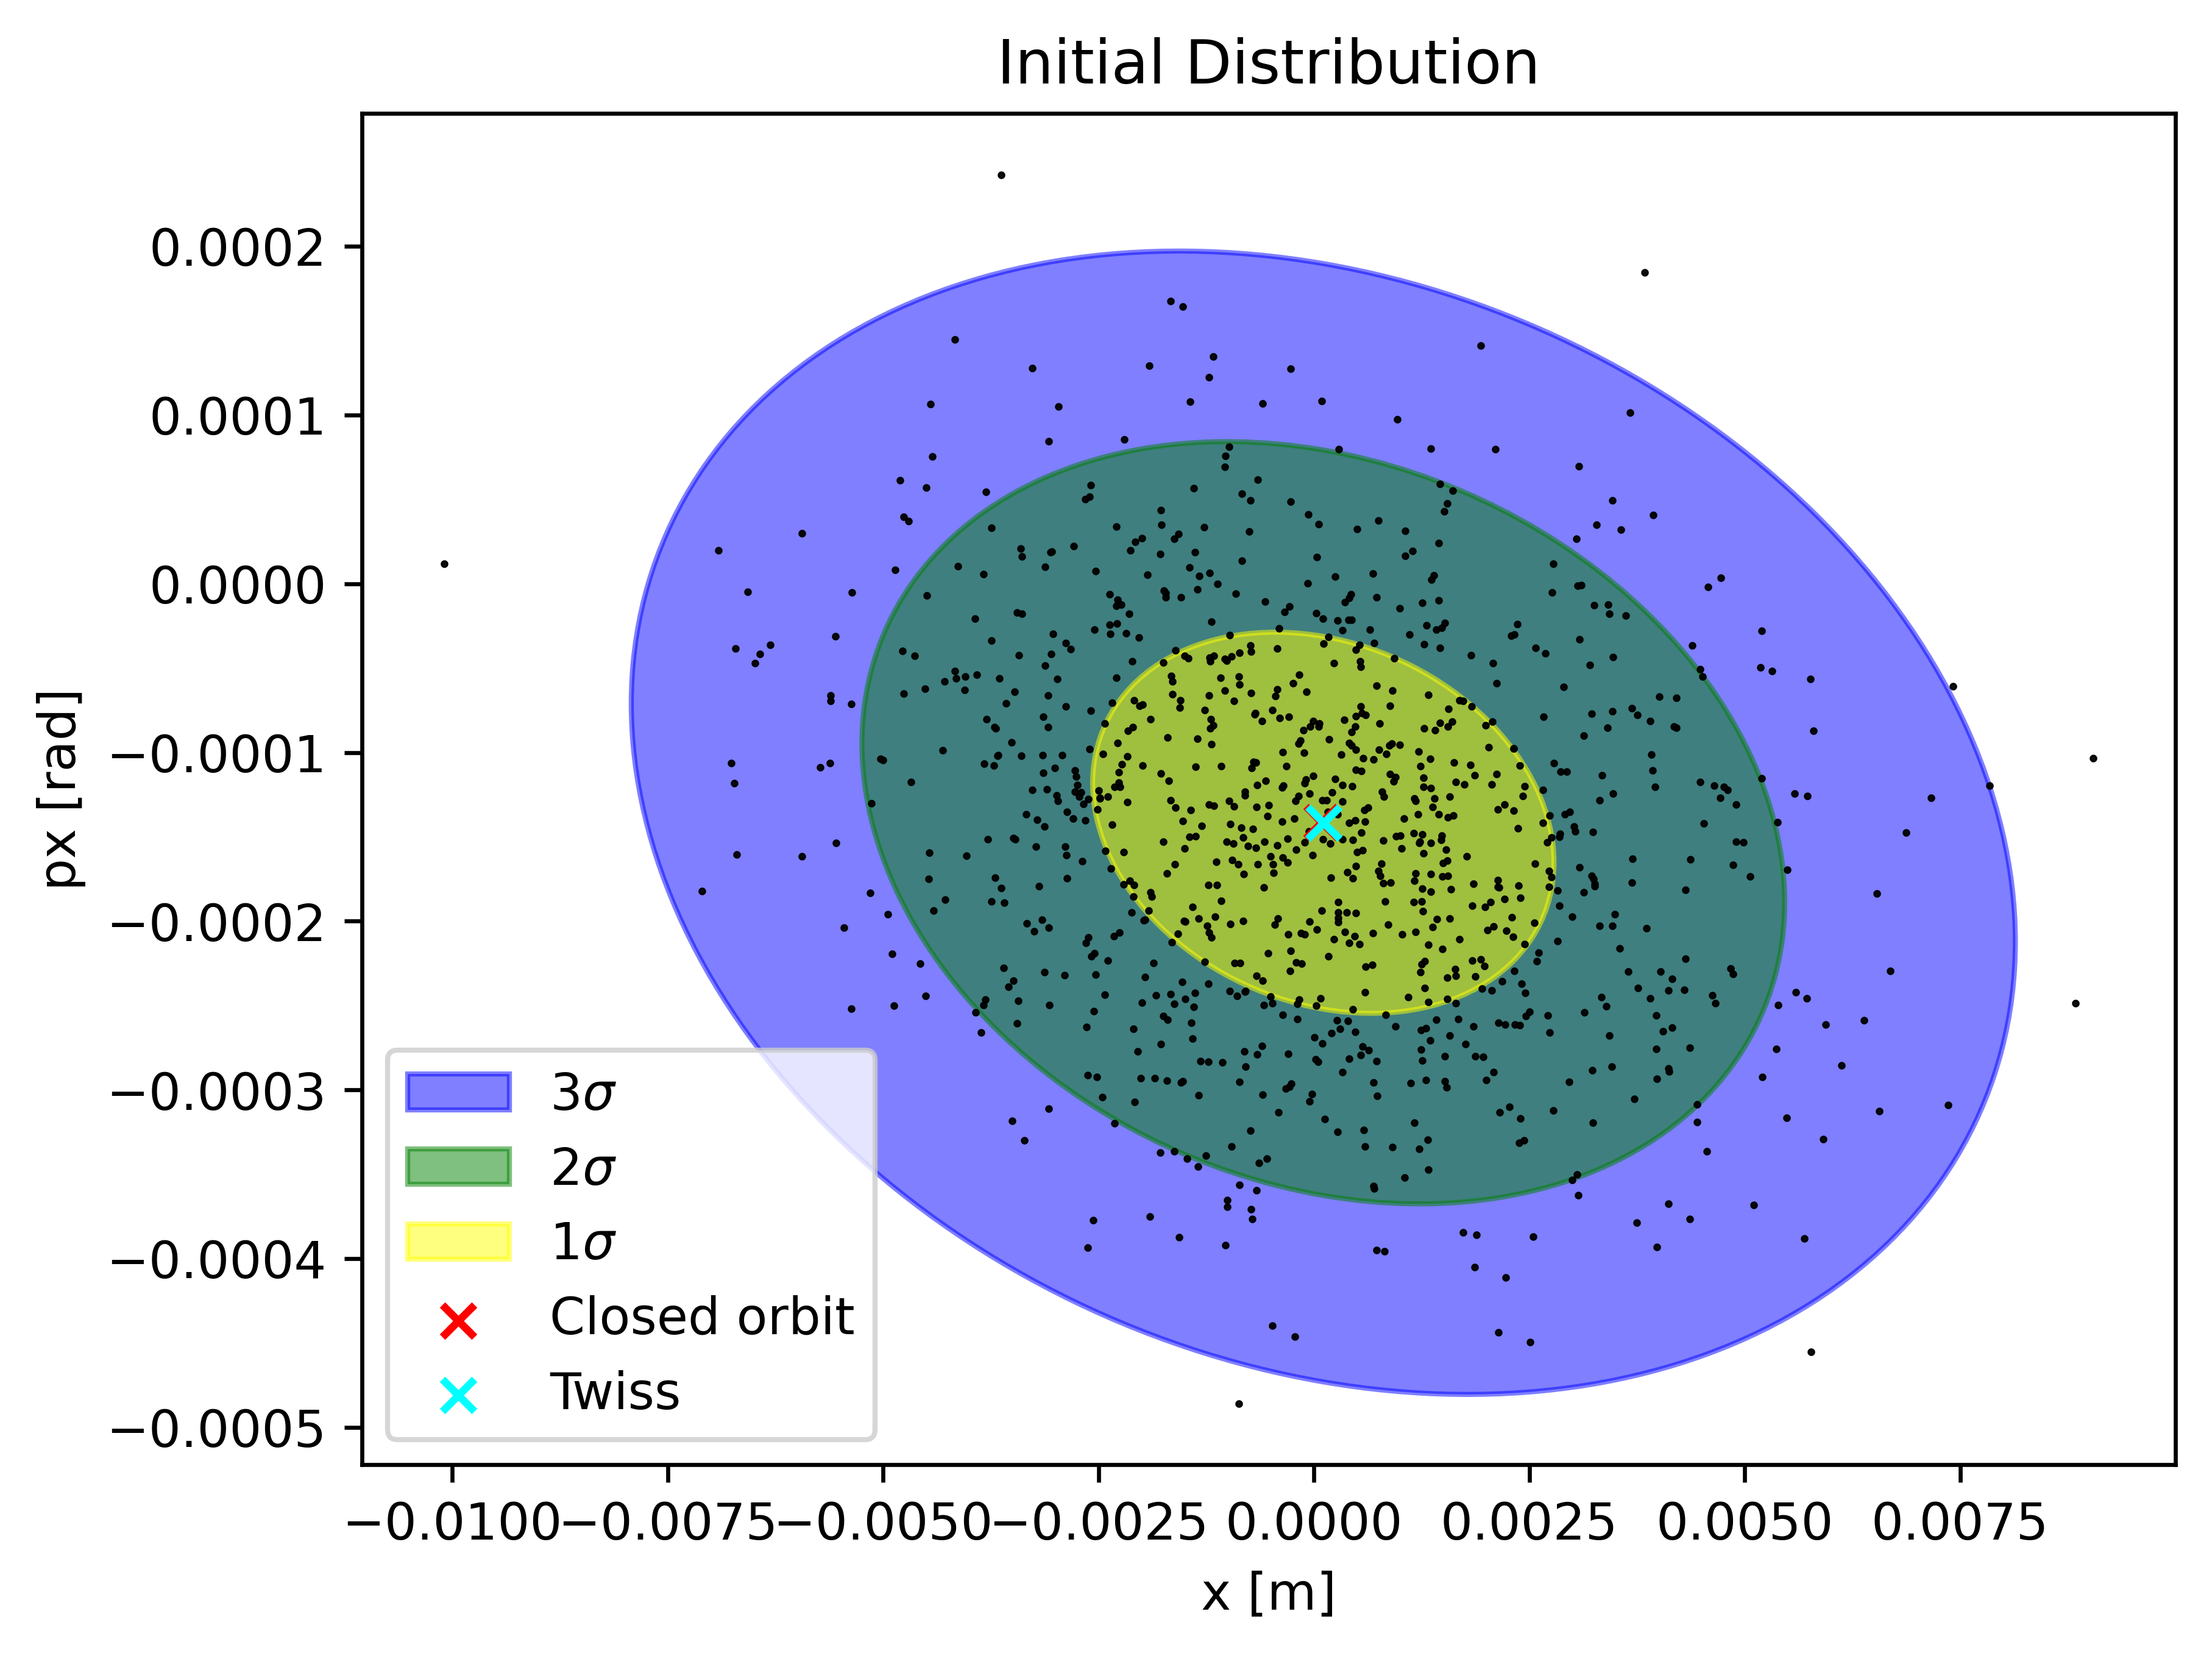

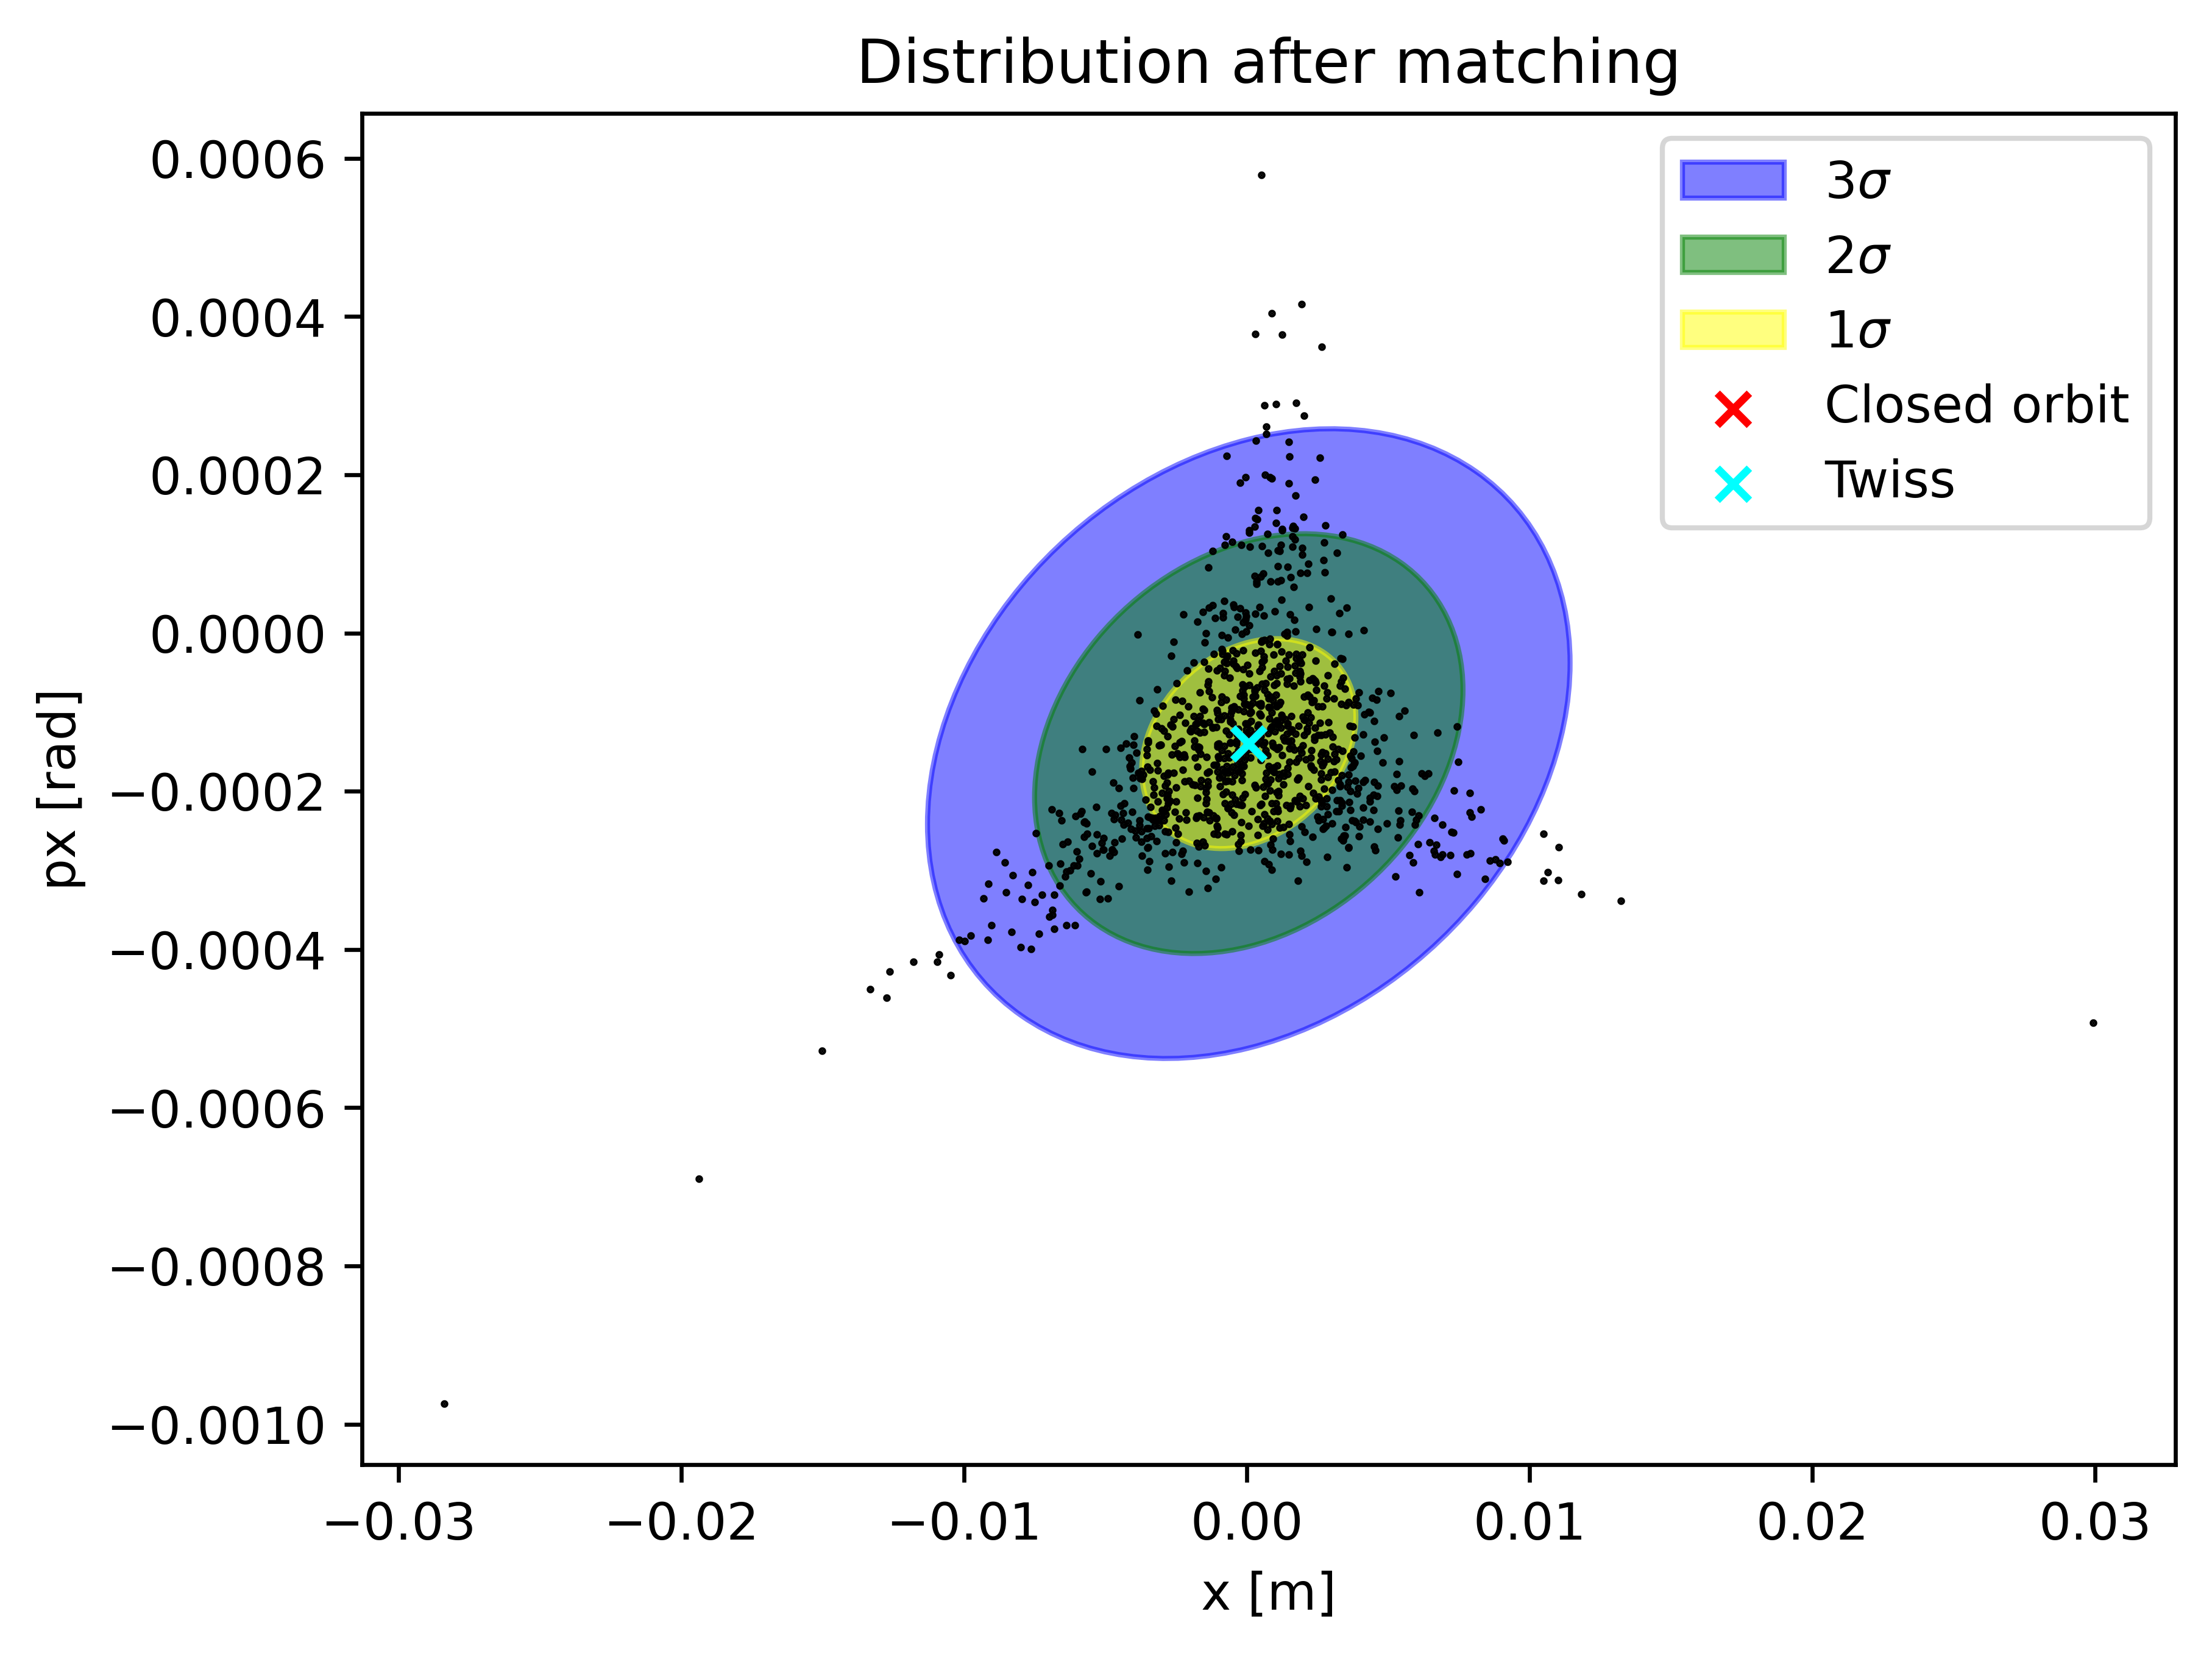

In [3]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

from progressbar import progressbar

import os
##########################################
###              CONSTANTS             ###
##########################################

REL_GAMMA = 25.598474067                    # relativistic gamma
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))       # relativistic beta
exn = 0.5e-6                                # emittance horizontal       
eyn = 0.5e-6                                # emittance vertical
ex = exn/(REL_BETA*REL_GAMMA)               # normalised emittance horizontal       
ey = eyn/(REL_BETA*REL_GAMMA)               # normalised emittance vertical

p = 5.392                                    # beam momentum (GeV/c)
momentum = 5.392                            # beam momentum (GeV/c)
Brho = p*3.3356                            # magnetic rigidity (Tm)

PS_radius = 70.079                          # radius of the PS (m)
DPP_FACTOR =  1.54e-3                           # momentum deviation factor

N_PART = int( 1000 )                         # number of particles

## QUAD COLLAPSE

TUNE_TARGET = 0.330                         # target tune
CHROMATICITY_TARGET = -0.5                  # target chromaticity
N_TURN = int( 500 )                         # number of turns for quad collapse

DETUNE_QUAD_KNL1 = -0.04                    # detune quad strength (kick)

## RFKO

CHIRP_START = .3                            # start freq of chirp (tune)
CHIRP_STOP = .35                            # stop freq of chirp (tune)
EXCITER_SAMPLING_FREQ = 1e6                 # sampling freq of exciter (Hz)


N_TURN_CHIRP = int( 1000 )                   # number of turns for chirp

SEPTA_X_MM = -60                            # septum x position (mm)

RFKO_STRENGTH = 1

DIR = f"."

##########################################
###              MAKE DIR              ###
##########################################

os.makedirs(DIR, exist_ok=True)
print(f"Directory: {DIR}")
mad = Madx(stdout=True)

##########################################
###             CALL PS MADX           ###
##########################################
# PS_REPO = "../../../models/acc-models-ps/"
# mad.call(PS_REPO+"ps_mu.seq")
# mad.call(PS_REPO+"ps_ss.seq")
# mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")
mad.call("../ps_24May.seq")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
# turn off 23 for ions
mad.input("kPEBSW23 := 0;")

mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')

def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    # madx.call(PS_REPO+"ps_mu.seq")
    # madx.call(PS_REPO+"ps_ss.seq")
    # madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")
    madx.call("../ps_24May.seq")
    madx.input("kprxse = 0;")
    madx.command.beam(particle='PROTON',
                      pc=p,
                      ex=ex,
                      ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')
    madx.use(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

# mad.input("kprxse = 0;")
# GET PFWS FOR TUNE
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=TUNE_TARGET,Qxp=CHROMATICITY_TARGET,Qy=0.3,Qyp=-0.242, p=p, ex=ex, ey=ey) # Chroma from measurements on 12.11.21 

# SET PFWS
mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

# FLATTEN
mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.command.install(element = 'marker_seh23', class_='MARKER', at=-0.4, from_='PE.SEH23')

# CYCLE
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")

initial_conditions = (-0.07, (-0.00135 + -0.0015)/2)
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss_cycled_beta = mad.twiss(x=initial_conditions[0], px=initial_conditions[1], beta0="bumped23").dframe()
twiss_cycled = mad.twiss().dframe()

twiss_before_makethin = mad.twiss().dframe()

# MAKETHIN
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

twiss_after_makethin = mad.twiss().dframe()

# CONVERT TO XTRACK
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence(),
    )


madx_smh57_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh57:1')[0][0]]



qse_29_ids = [i for i, n in enumerate(line.element_names) if "qse29" in n]
qse_87_ids = [i for i, n in enumerate(line.element_names) if "qse27" in n]

##########################################
###             SET UP LINE            ###
##########################################

detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)
ctx = xo.ContextCpu()
line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)
line.build_tracker()
co_guess = line.build_particles(
    x = initial_conditions[0],
    px = initial_conditions[1],
)
tw = line.twiss(method='4d')

print(f"Dispersion at seh23: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'seh23' in n][0]]}")
print(f"Dispersion at smh57: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'smh57' in n][0]]}")
FREV = 1/tw['T_rev0']


##########################################
###            BUILD PARTICLES         ###
##########################################
# TODO: Explain why approximations, or show its the same without approximations
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)
particles = line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)
line.unfreeze()

RF_VOLTAGE = 130e3

RF_HARMONIC = 8
RF_FREQUENCY = FREV * RF_HARMONIC
PHASE = 0 # rising-edge

rf_cavity = xt.Cavity(
    _context = ctx,
    voltage = RF_VOLTAGE,
    frequency = RF_FREQUENCY,
    lag = PHASE
)

line.insert_element(
    element = rf_cavity,
    name = "rf_cavity",
    at_s = 0
)
line.build_tracker()
# particles = xp.generate_matched_gaussian_bunch(
#         line = line,
#         num_particles = int(N_PART),
#         nemitt_x = exn,
#         nemitt_y = eyn,
#         sigma_z = 4.3,
#         total_intensity_particles = 30e10
# )

##########################################
###            PLOT INIT DIST          ###
##########################################

cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = line.find_closed_orbit()
tw = line.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Initial Distribution")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')

fig.savefig(f"{DIR}/initial_distribution.png")


##########################################
###       ADD MONITORS AND SEPTA       ###
##########################################

line.unfreeze()
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)
septum = xt.LimitRect(
    min_x = SEPTA_X_MM*0.001, # in meters
)
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)
line.build_tracker()

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

# Track
tunes = []
strengths = []
# print(f"Tracking for particle {N_TURN} for detuning, {N_TURN_CHIRP} for rfko")

##########################################
###         DETUNE QUAD COLLAPSE       ###
##########################################

delta = line['DETUNING_QUAD'].knl[1]/N_TURN
for turn in range(N_TURN):
    # Detuning
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    line.track(particles)
    tune = line.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])
tune_before = tw['qx']
print(f"Tune before detune: {tune_before}")
tw = line.twiss(method='4d')
tune_after = tw['qx']
print(f"Tune after detune: {tune_after}")
RAD_TO_MRAD = 1000
M_TO_MM = 1000




cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = line.find_closed_orbit()
tw = line.twiss(method='4d')
parms = pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Distribution after matching")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')



In [4]:
interval = 1
frev = FREV

RAD_TO_MRAD = 1000
M_TO_MM = 1000
MS_TO_S = 1e-3

from signal_gen import generate_afg_chirp

sampling_freq = 1e9
chirp_time, chirp_signal, chirp_turns = generate_afg_chirp(
    chirp_rep_time = float(interval)*MS_TO_S,
    turn_freq = frev,
    chirp_middle = frev * 0.325,
    chirp_dev = frev * 0.025,
    sampling_freq = sampling_freq
)

###############################################
#  _______     ________  ___  ____    ___     #
# |_   __ \   |_   __  ||_  ||_  _| .'   `.   #
#   | |__) |    | |_ \_|  | |_/ /  /  .-.  \  #
#   |  __ /     |  _|     |  __'.  | |   | |  #
#  _| |  \ \_  _| |_     _| |  \ \_\  `-'  /  #
# |____| |___||_____|   |____||____|`.___.'   #
#                                             #
###############################################
                                           
def kick_angle(gain):
    c = sp.constants.c # m/s, speed of light
    E0 = 0.93827e9 # eV, proton rest energy
    mu0 = 4*np.pi*(10**-7) # H/m, vacuum permeability

    T = (np.sqrt(Brho**2+E0/1e9**2)-E0/1e9)*1e9 # eV, proton KE
    P = 5e3 # W, TFB peak power / electrode
    Z = 100 # Ohm, TFB impedance / electrode

    L = 935e-3 # m, TFB length
    r = 70e-3 # m, TFB separation

    E = T + E0 # Total Energy
    gamma = E / E0 # Normalized energy (lorentz)
    beta = np.sqrt(1-gamma**-2) # normalised velocity (lorentz)
    cp = np.sqrt(E**2 - E0**2) # eV, particle momentum

    # Electric Field
    Vp = np.sqrt(P * Z * 2) # peak voltage
    V = Vp * gain
    Efield = V / r # adjusted for gain

    # Magnetic Field
    I = np.sqrt((V**2/Z)/Z*2) # current
    Hfield = (2*I) / (2*np.pi*r) # adjusted for gain
    Bfield = Hfield * mu0

    # Angle
    theta_M = c/1e9*Bfield*L / (cp/10**9)
    theta_E = Efield/1e9*L / (cp/10**9 * beta)
    theta = theta_E + theta_M
    return theta

rfko_kick = kick_angle(float(1))

mad.use(sequence="PS")
line.unfreeze()
rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [rfko_kick],
    #duration = N_TURN_CHIRP/FREV
)
line.insert_element(
    element = rfko_exciter,
    name = f'EXCITER',
    index = 'pr.kfb97'
)
line.build_tracker()
line.track(particles, num_turns = N_TURN_CHIRP)
loss_list = list(zip(particles.at_turn, zip(particles.x, particles.px)))


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [5]:
import matplotlib as mpl
# dpi 600
mpl.rcParams['figure.dpi'] = 600

In [7]:
cov = np.cov([smh57_monitor.x.T[0], smh57_monitor.px.T[0]])
cov_px = np.cov(smh57_monitor.px.T[0])

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

line.unfreeze()
line.build_tracker()
co = line.find_closed_orbit()
tw = line.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
smh57loc = [i for i, n in enumerate(tw['name']) if "SMH57" in n][0]

Text(0.5, 1.0, 'Phase Space population at SMH57')

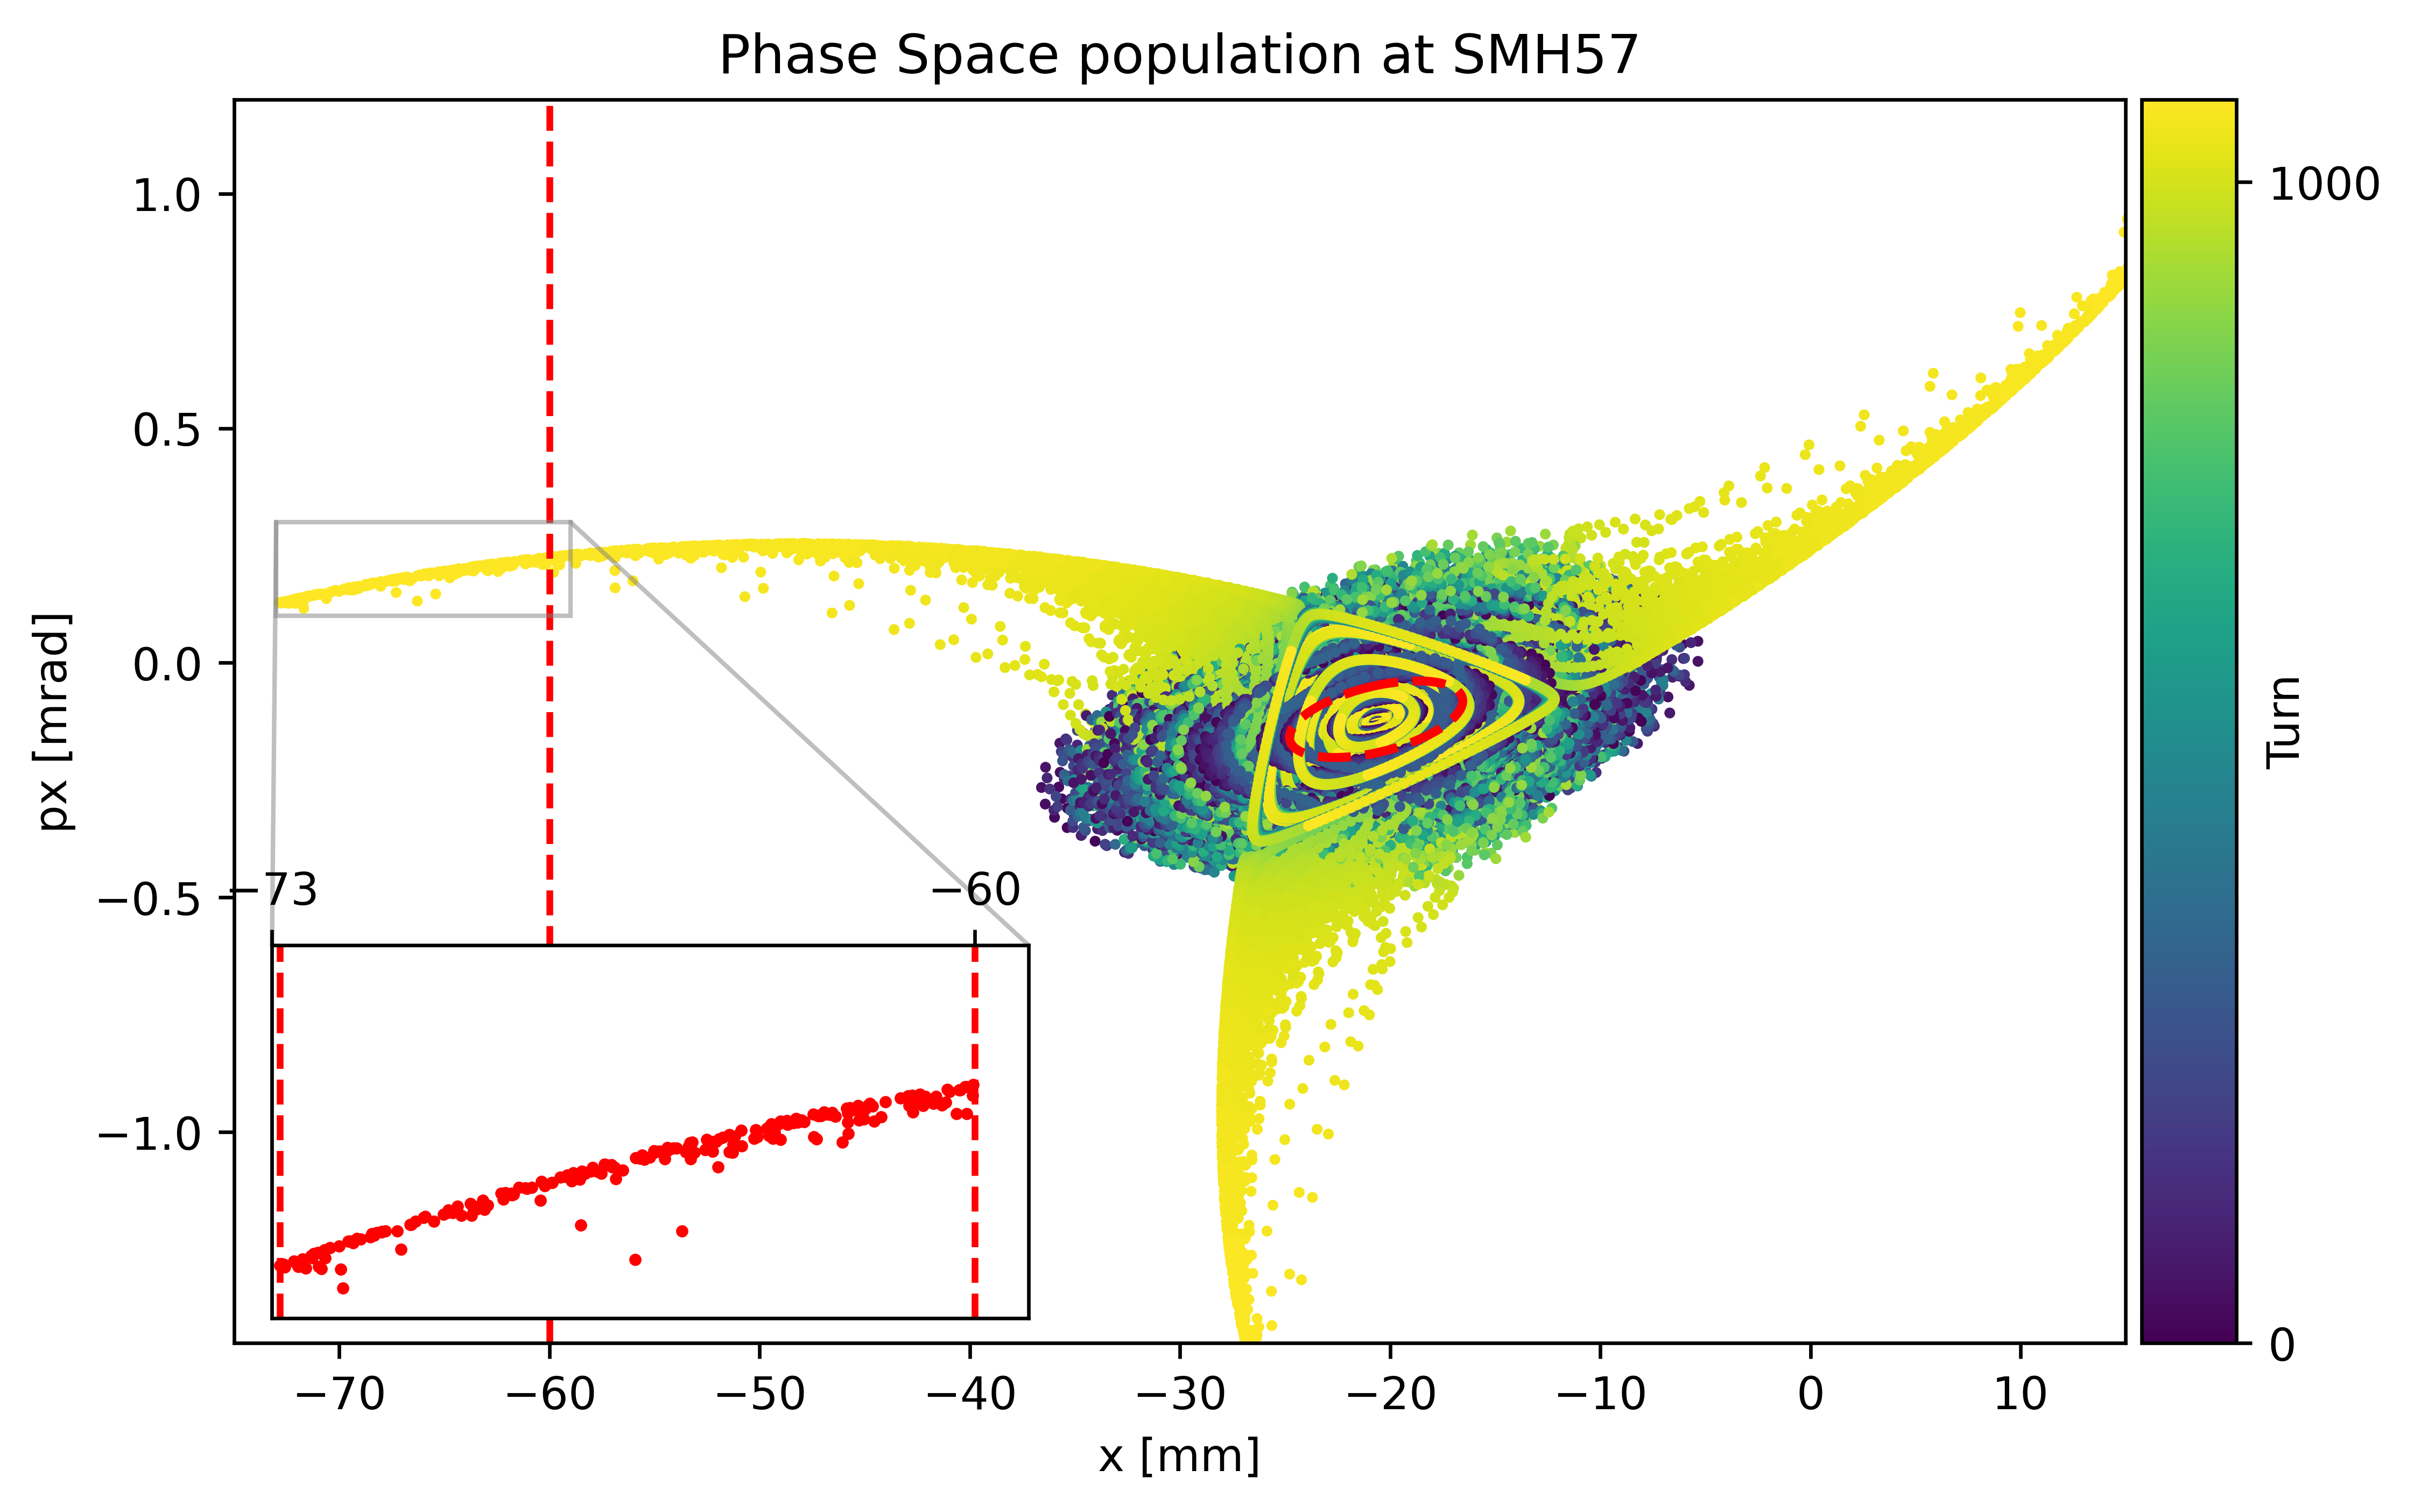

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
# import colors
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# get viridis colormap
cm = plt.get_cmap('viridis')
for i in range(N_PART):
    sctr = ax.scatter(M_TO_MM*smh57_monitor.x[i], RAD_TO_MRAD*smh57_monitor.px[i], cmap=cm, c=smh57_monitor.at_turn[i], s=2)
ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')


e1 = Ellipse(
    xy=(tw.x[smh57loc]*M_TO_MM, tw.px[smh57loc]*RAD_TO_MRAD), 
    width=w1*M_TO_MM, height=h1*M_TO_MM, angle=r1, 
    fc='none', 
    label='2$\sigma$', 
    ec='red', 
    lw=2,
    ls='--',
    zorder=10,)


ax.add_artist(e1)

axins = ax.inset_axes([0.02, 0.02, 0.4, 0.3])
x1 = -70
x2 = -59
y1 = 0.1
y2 = 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.scatter(particles.x*M_TO_MM, particles.px*RAD_TO_MRAD, s=3, c='red')
axins.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
axins.axvline(min(particles.x*M_TO_MM), color='red', linestyle='--')
axins.xaxis.tick_top()
axins.yaxis.tick_right()
axins.set_xticks([round(min(particles.x*M_TO_MM),0), round(SEPTA_X_MM, 0)])
axins.set_yticks([])

ax.scatter(0, 0, s=5, c='white')

ax.indicate_inset_zoom(axins)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sctr, cax=cax, orientation='vertical')
cax.set_ylabel("Turn")
cax.yaxis.set_label_coords(1.3, .5)

cax.set_yticks([cax.get_yticks()[0], cax.get_yticks()[-2]])
cax.set_yticklabels([0, N_TURN_CHIRP])
ax.set_xlim(-75, 15)
ax.set_ylim(-1.45, 1.2)
ax.set_xlabel("x [mm]")
ax.set_ylabel("px [mrad]")
ax.set_title("Phase Space population at SMH57")